In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2021-01-10 00:00"    #date and time to start collecting candles
end = ""                      #date and time to end the collection of candles, if "", then end will be now.
granularity = "H2"
instrument = "EUR_ZAR"

In [5]:
df = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
#df = pd.read_csv("EUR_USD_M15.csv", index_col=0)
print(df.shape)
df.head()

(3482, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-10T22:00:00,18.70332,18.72326,18.64580,18.66268,26167.0
2021-01-11T00:00:00,18.66272,18.73520,18.66129,18.72254,37177.0
2021-01-11T02:00:00,18.72256,18.77306,18.68350,18.69754,42408.0
2021-01-11T04:00:00,18.69764,18.92202,18.69740,18.81141,61064.0
2021-01-11T06:00:00,18.81126,18.88084,18.75822,18.84628,68847.0


In [6]:
import talib as ta
from talib import MA_Type

def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    # rolling mean ist das Beste Feature! ever für SVM
    # 6 original features
    df_new['Close'] = df['Close'].rolling(window=7).mean() 
    df_new['Close2'] = df['Close'] 
    df_new['Open'] = df['Open'].rolling(window=7).mean() 
    df_new['High'] = df['High'].rolling(window=7).mean()  
    df_new['Low'] = df['Low'].rolling(window=7).mean()    
    df_new['Volume'] = df['Volume'].rolling(window=7).mean()
    
    df_new['EMA_5'] = ta.EMA(df['Close'], timeperiod=5)
    df_new['EMA_15'] = ta.EMA(df['Close'], timeperiod=15)

    
    df_new['MFI_5'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=5)
    df_new['MFI_15'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=15)
    df_new['MFI_30'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=30)
    df_new['MFI_60'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=60)
    df_new['MFI_90'] = ta.MFI(df['High'], df['Low'], df['Close'],df['Volume'], timeperiod=90)
    

    df_new['Open-Low'] = df['Open'] - df['Low']
    df_new['High-Close'] = df['High'] - df['Close']
    
    df_new['Low-Open'] = df['Low'] - df['Open']  
    df_new['Close-High'] = df['Close'] - df['High']  
    

    
  
    df_new = df_new.dropna(axis=0)
    return df_new

In [7]:
df = generate_features(df)
df.tail()

,Close,Close2,Open,High,Low,Volume,EMA_5,EMA_15,MFI_5,MFI_15,MFI_30,MFI_60,MFI_90,Open-Low,High-Close,Low-Open,Close-High
Date,,,,,,,,,,,,,,,,,
2022-02-18T10:00:00,17.047581,17.11700,17.034050,17.063399,17.014064,27789.142857,17.063183,17.052640,50.519210,53.758619,46.944977,47.174007,47.452987,0.01484,0.01538,-0.01484,-0.01538
2022-02-18T12:00:00,17.052844,17.09040,17.047533,17.069600,17.018484,33886.285714,17.072256,17.057360,43.892541,45.334844,44.062903,45.033883,46.676576,0.06344,0.02813,-0.06344,-0.02813
2022-02-18T14:00:00,17.069851,17.15256,17.052761,17.085123,17.024039,36841.142857,17.099024,17.069260,66.979589,56.431808,47.967456,47.797337,47.651009,0.02031,0.01351,-0.02031,-0.01351
2022-02-18T16:00:00,17.087963,17.15796,17.069727,17.104869,17.031690,43269.000000,17.118669,17.080347,81.171999,64.388220,51.639001,50.353541,49.058773,0.07676,0.02384,-0.07676,-0.02384
2022-02-18T18:00:00,17.105423,17.14282,17.087859,17.122586,17.045414,42240.714286,17.126719,17.088156,67.155970,67.534971,49.534496,47.183193,48.705334,0.04945,0.01912,-0.04945,-0.01912


In [8]:
#df = df.reset_index()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3392 entries, 2021-01-20T10:00:00 to 2022-02-18T18:00:00
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       3392 non-null   float64
 1   Close2      3392 non-null   float64
 2   Open        3392 non-null   float64
 3   High        3392 non-null   float64
 4   Low         3392 non-null   float64
 5   Volume      3392 non-null   float64
 6   EMA_5       3392 non-null   float64
 7   EMA_15      3392 non-null   float64
 8   MFI_5       3392 non-null   float64
 9   MFI_15      3392 non-null   float64
 10  MFI_30      3392 non-null   float64
 11  MFI_60      3392 non-null   float64
 12  MFI_90      3392 non-null   float64
 13  Open-Low    3392 non-null   float64
 14  High-Close  3392 non-null   float64
 15  Low-Open    3392 non-null   float64
 16  Close-High  3392 non-null   float64
dtypes: float64(17)
memory usage: 477.0+ KB


In [10]:
df.head()

,Close,Close2,Open,High,Low,Volume,EMA_5,EMA_15,MFI_5,MFI_15,MFI_30,MFI_60,MFI_90,Open-Low,High-Close,Low-Open,Close-High
Date,,,,,,,,,,,,,,,,,
2021-01-20T10:00:00,18.130627,18.06983,18.146199,18.169843,18.108393,44122.714286,18.100363,18.161395,-5.426935e-15,30.380628,51.835925,44.966028,46.158244,0.05767,0.02519,-0.05767,-0.02519
2021-01-20T12:00:00,18.114117,18.08399,18.130593,18.154166,18.093407,49719.142857,18.094905,18.151720,1.864069e+01,37.143475,47.371017,46.652442,46.271732,0.00082,0.04659,-0.00082,-0.04659
2021-01-20T14:00:00,18.087637,18.01178,18.114096,18.137446,18.065217,57477.428571,18.067197,18.134227,1.790458e+01,36.521977,42.163595,46.922023,45.256856,0.09566,0.08254,-0.09566,-0.08254
2021-01-20T16:00:00,18.071147,18.03928,18.087614,18.116826,18.043666,61495.714286,18.057891,18.122359,1.670271e+01,35.880510,38.140844,45.046447,44.177302,0.01784,0.01508,-0.01784,-0.01508
2021-01-20T18:00:00,18.057064,18.04200,18.071134,18.101917,18.028267,58469.857143,18.052594,18.112314,3.357242e+01,42.443350,37.705604,46.578982,43.993213,0.01626,0.02030,-0.01626,-0.02030


In [11]:
# gamma helps to find the decision boundary 

sigma = 10
gamma = 1/(2 * sigma **2)



Y = np.where(df['Close'].shift(-2) > df['Close'],1,-1)
X = df[['Low-Open', 'Close-High', 'MFI_5']]

split_percentage = 0.7
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
Y_train = Y[:split]

# Test data set
X_test = X[split:]
Y_test = Y[split:]
#print(Df)
cls = SVC(kernel = 'rbf', gamma = gamma, C = 3, decision_function_shape = 'ovr').fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, cls.predict(X_train))
accuracy_test = accuracy_score(Y_test, cls.predict(X_test))

print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 73.67%
Test Accuracy: 75.44%


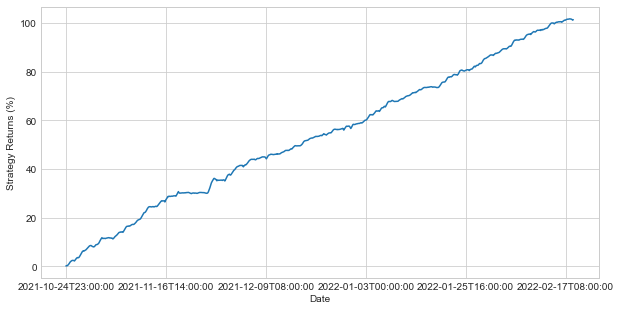

In [12]:
# I am trying to create a backtest that takes the Close2 price when the signal starts into
# one direction until the signal changes and calculates the return after the change


df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
df['Return'] = np.log(df.Close.shift(-2) / df.Close)*100
df['Strategy_Return'] = df.Return * df.Predicted_Signal
df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [13]:

X=df[['Low-Open', 'Close-High', 'MFI_5']][-1:]
position = int(cls.predict(X))

In [14]:
print(position)

1


<AxesSubplot:xlabel='Date'>

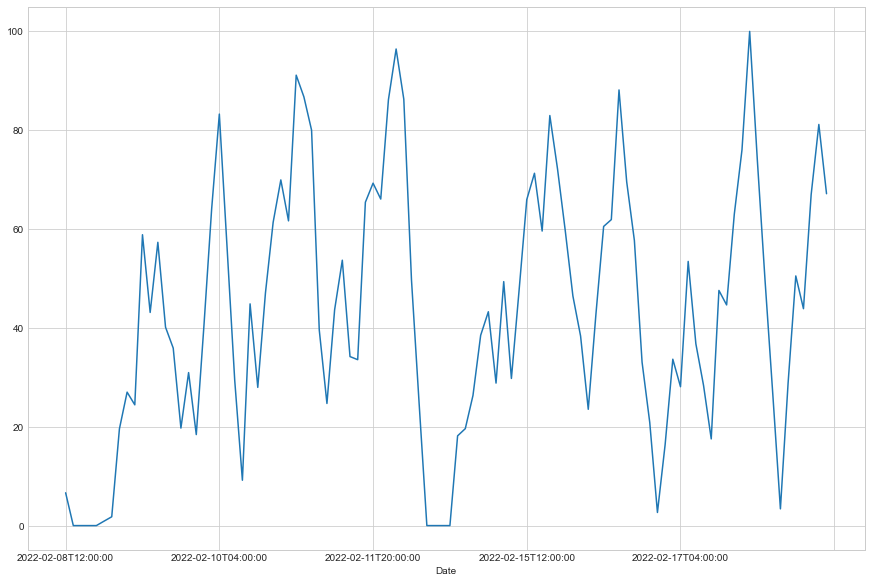

In [15]:
df['MFI_5'][-100:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

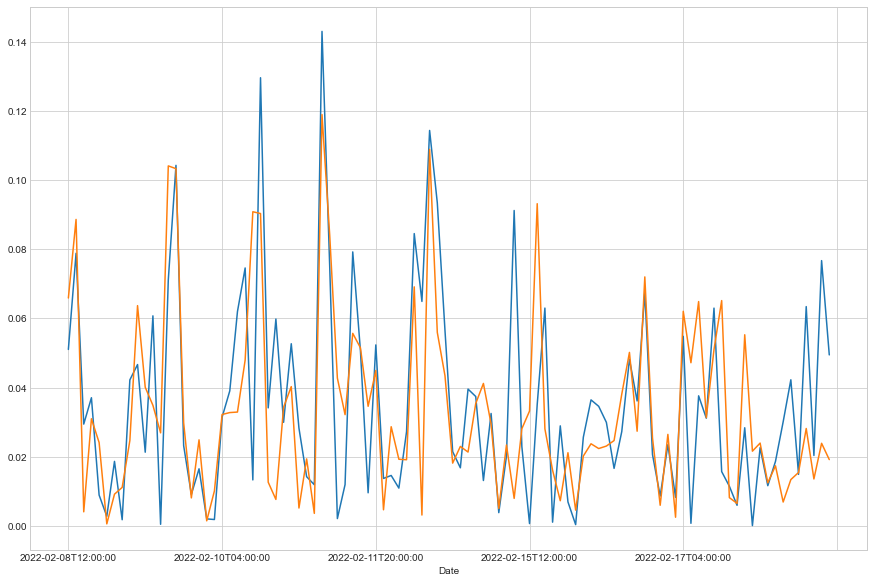

In [16]:
df['Open-Low'][-100:].plot(figsize=(15,10))
df['High-Close'][-100:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

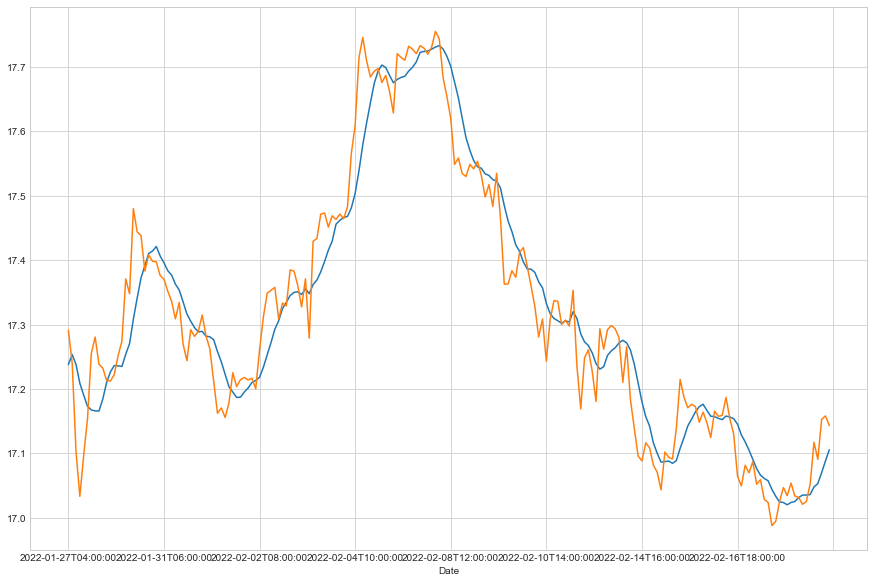

In [17]:
df['Close'][-200:].plot(figsize=(15,10))
df['Close2'][-200:].plot(figsize=(15,10))